<h1> Modelling and evaluation </h1>
<h2> 1. Import and download </h2>

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score as ACC
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from keras import layers
from keras.layers import RNN, Dense, Dropout, BatchNormalization
from keras import Sequential, layers, Input, callbacks

import warnings
warnings.filterwarnings('ignore')

In [117]:
# Importing all the datasets
train_A = pd.read_csv('data/train_A.csv')
val_A = pd.read_csv('data/val_A.csv')
test_A = pd.read_csv('data/test_A.csv')


train_B = pd.read_csv('data/train_B.csv')
val_B = pd.read_csv('data/train_df.csv')
test_B = pd.read_csv('data/test_df.csv')


train_C = pd.read_csv('data/train_C.csv')
val_C = pd.read_csv('data/val_C.csv')
test_C = pd.read_csv('data/test_C.csv')


train_D = pd.read_csv('data/train_D.csv')
val_D= pd.read_csv('data/val_D.csv')
test_D = pd.read_csv('data/test_D.csv')


# B1 = pd.read_csv('data/train_df.csv')
# B2= pd.read_csv('data/val_df.csv')
# B3 = pd.read_csv('data/test_df.csv')

<h2> 2. Data preprocessing </h2>

In [121]:
datasets = [# train_A, val_A, test_A, 
            train_B, val_B, test_B, 
            train_C, val_C, test_C,
            train_D, val_D, test_D]


In [122]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "ARAGORN"]

# Creating a common label for the characters not of interest
def common_label_removal(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data

def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    print(names)
    print(np.unique(encoded_data))
    return encoded_data, names

def preprocessing(data):
    data = common_label_removal(data)
    x_data, y_data = x_y_split(data)
    y_data = char_2_num(y_data)
    return x_data, y_data

for i in range(len(datasets)):
    datasets[i] = preprocessing(datasets[i])

['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']
[0 1 2 3 4 5 6 7 8 9]
['ARAGORN', 'FARAMIR', 'FRODO', 

In [123]:
B_tra_X =datasets[0][0]
B_tra_y =datasets[0][1][0]
B_val_X =datasets[1][0]
B_val_y=datasets[1][1][0]
B_tar_X=datasets[2][0]
B_tar_y=datasets[2][1][0]

C_tra_X =datasets[3][0]
C_tra_y =datasets[3][1][0]
C_val_X =datasets[4][0]
C_val_y=datasets[4][1][0]
C_tar_X=datasets[5][0]
C_tar_y=datasets[5][1][0]

D_tra_X =datasets[6][0]
D_tra_y =datasets[6][1][0]
D_val_X =datasets[7][0]
D_val_y=datasets[7][1][0]
D_tar_X=datasets[8][0]
D_tar_y=datasets[8][1][0]

<h2> 2. Benchmarks </h2>
<h3> 2.1 Naive Benchmark, Monte Carlo Method </h3>
<p> Using 1000 simulations with random guesses on target labels. </p>

In [124]:
def naive_benchmark_MonC(y):
    accuracy_list = []
    for i in range(0,1000,1):
        naive_rand_pred = np.random.randint(0,12,size=(len(y)))
        accuracy_sel = ACC(naive_rand_pred, y)
        accuracy_list.append(accuracy_sel)
    return np.mean(accuracy_list)

In [125]:
naive_benchmark_MonC(A_tar_y)

0.08308547008547008

<h3> 2.2 Naive Benchmark, Majority Class Method </h3>
<p> Using Frodo, which equals label 2, as guess </p>

In [126]:
def naive_benchmark_MajC(y):
    pred_MCNB =np.repeat(2,len(y))
    return ACC(pred_MCNB, y)

In [127]:
naive_benchmark_MajC(A_tar_y)

0.1752136752136752

<h2> 3. Modelling  </h2>
<!-- <h3> 3.1 ANN on dataset A</h3> -->
<!-- <p> Dataset A contains various numerical retrieved from the characters. </p>
<p> The feedforward neural network has a relative simple architecture. -->

In [128]:
# scaler = StandardScaler()
# # A1 = scaler.fit_transform(D_tra_X)
# # A2 = scaler.transform(D_val_X)
# # A3 = scaler.transform(D_tar_X)
# A1 = D_tra_X.reset_index(drop=True)
# A2 = D_val_X.reset_index(drop=True)
# A3 = D_tar_X.reset_index(drop=True)

# Y1 = np.eye(10)[D_tra_y]
# Y2 = np.eye(10)[D_val_y]
# Y3 = np.eye(10)[D_tar_y]

In [12]:
# ann_model = keras.Sequential([
#     layers.Dense(8, activation='relu',input_dim=20),
#     layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
#     # layers.Dense(16, activation='selu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.3),
#     layers.Dense(10, activation='softmax'),
#     layers.Dense(10)
# ])

# optimizer = keras.optimizers.Adam(learning_rate=0.01)
# ann_model.compile(optimizer=optimizer,
#               loss = 'categorical_crossentropy',
#               metrics=['accuracy']
#               )

# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=35, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )
# ann_model.fit(A1, Y1, 
#           validation_data= (A2, Y2),
#           epochs=200, batch_size=10, 
#           callbacks=early_stopping,
#           verbose=0
#           )

# print('Accuracy train: ',ann_model.evaluate(A1, Y1))
# print('Accuracy validation: ',ann_model.evaluate(A2, Y2))
# print('Accuracy test: ',ann_model.evaluate(A3, Y3))

<h3> 3.1 XGBC on dataset D

In [130]:
from xgboost import XGBClassifier 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [131]:
p_g = {
    'objective':['multi:softprob'],
    'alpha': hp.uniform('alpha',0,1),
    'gamma': hp.uniform('gamma',0,9),
    'reg_lambda':hp.quniform('reg_lamda',0,3,1),
    'max_depth':hp.quniform('max_depth',6,12,1),
    'learning_rate': hp.uniform('learning_rate',0.001,0.05),
    'n_estimators': hp.quniform('n_estimators', 5,500,1),
    'min_child_weight': hp.quniform('min_child_weight',0,5,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'seed':42
    }

In [15]:
from sklearn.model_selection import cross_val_score

In [132]:
def bayopt_xgb(p_g):
    internal_model = XGBClassifier(
                     objective='multi:softmax',
                     alpha=p_g['alpha'],
                     gamma=p_g['gamma'],
                     reg_lambda= p_g['reg_lambda'],
                    #  colsample_bytree= p_q['colsample_bytree'],
                     max_depth = int(p_g['max_depth']),
                     n_estimator = (p_g['n_estimators']),
                     learning_rate=p_g['learning_rate'],
                    #  min_child_weight=p_g['min_child_weight'],
                     seed =p_g['seed'],
                     )
    # evaluation = [(A2, A_val_y)]

    internal_model.fit(D_tra_X, D_tra_y,
                     eval_set = [(D_val_X, D_val_y)],
                     eval_metric = 'mlogloss',
                     early_stopping_rounds=25,verbose=False)
    
    # pred_valid = internal_model.predict(A2)
    # score = ACC(pred_valid, A_tra_y)

    score =np.mean(cross_val_score(internal_model, D_tra_X, D_tra_y, scoring='accuracy', cv=5))
    print('Score:', score)
    return {'loss':-score, 'status':STATUS_OK}

def tune():
    trials = Trials()
    best_tune = fmin(fn=bayopt_xgb, 
                    space=p_g,
                    algo= tpe.suggest,
                    max_evals=5,
                    trials=trials)
    return best_tune


ntune = tune()
ntune['n_estimators'] =  int(ntune['n_estimators'])
ntune['max_depth'] =  int(ntune['max_depth'])
xmodel = XGBClassifier(**ntune)

Score:                                               
0.2615264856654642                                   
Score:                                                                          
0.2885513575090184                                                              
Score:                                                                          
0.293787734953484                                                               
Score:                                                                          
0.2894285171824568                                                             
Score:                                                                         
0.2562901082209987                                                             
100%|██████████| 5/5 [02:31<00:00, 30.33s/trial, best loss: -0.293787734953484]


In [134]:
xmodel.fit(D_tra_X, D_tra_y)

XGBClassifier(alpha=0.827300665245092, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9739853108897678, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.579957659947107,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025404873818848102,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=4.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=323, n_jobs=None,
              num_parallel_tree=None, ...)

In [135]:
print('Accuracy train: ',ACC(xmodel.predict(D_tra_X),D_tra_y))
print('Accuracy validation: ',ACC(xmodel.predict(D_val_X),D_val_y))
print('Accuracy test: ',ACC(xmodel.predict(D_tar_X),D_tar_y))

Accuracy train:  0.3295553618134263
Accuracy validation:  0.25196850393700787
Accuracy test:  0.27350427350427353


In [22]:
# A1a

In [23]:
# internal_model = XGBClassifier(
#                             objective='multi:softmax',
#                                 #  alpha=p_q['alpha'],
#                                 #  gamma=p_q['gamma'],
#                                 #  reg_lambda= p_q['reg_lambda'],
#                                 #  colsample_bytree= p_q['colsample_bytree'],
#                             # max_depth = int(p_g['max_depth']),
#                             max_depth = int(3),

#                             n_estimator = (p_g['n_estimators']),
#                             learning_rate=p_g['learning_rate'],
#                             #  min_child_weight=p_g['min_child_weight'],
#                             seed =p_g['seed'],
#                             )
# evaluation = [(A2, A_val_y)]

# internal_model.fit(A1, A_tra_y,
#                 eval_set = evaluation,
#                 eval_metric = 'mlogloss',
#                 early_stopping_rounds=25,verbose=False)
    
# pred_valid = internal_model.predict(A2)
# score = ACC(A2, A_tra_y)
#     # return pred_valid

# print('Score:', score)
# {'loss':-score, 'status':STATUS_OK}

# def tune():
#     trials = Trials()
#     best_tune = fmin(fn=internal_model, 
#                     space=p_g,
#                     algo= tpe.suggest,
#                     max_evals=200,
#                     trials=trials)
#     return best_tune


# ntune = tune()
# ntune['n_estimators'] =  int(ntune['n_estimators'])
# ntune['max_depth'] =  int(ntune['max_depth'])
# # xmodel = XGBClassifier(**ntune)

In [24]:

# def cvscore():
#     ntune = tune()
#     ntune['n_estimators'] =  int(ntune['n_estimators'])
#     ntune['max_depth'] =  int(ntune['max_depth'])
#     xmodel = XGBClassifier(**ntune, random_state=42)
#     cvs = cross_val_score(xmodel, A1, Y1, cv=25,
#                          random_state=42)
#     cvs.predict
#     return cvs.mean()

<h3> 3.2 RNN on dataset B </h3>
<p> Dataset B contains embeddings(?). This, I need to read myself up on.</p>

In [136]:
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model

In [144]:
B1 = pd.read_csv('data/train_df.csv')
B2= pd.read_csv('data/val_df.csv')
B3 = pd.read_csv('data/test_df.csv')

In [145]:
B1 = common_label_removal(B1).reset_index(drop=True)
B2 = common_label_removal(B2).reset_index(drop=True)
B3 = common_label_removal(B3).reset_index(drop=True)

In [146]:
def quote_list(X):
    quote_list = []
    for quote in range(len(X)):
        splitted_quote =  X['dialog'][quote].split()
        sequence_list = []
        for split in range(len(splitted_quote)):
            splitted_word = splitted_quote[split]

            word_list = str()
            i=0
            while i < (len(splitted_word)):
                # print(splitted_word[i])
                if splitted_word[i].isalpha() == True:
                    word_list += splitted_word[i]
                i+=1
            sequence_list.append(word_list)
        quote_list.append(sequence_list)
    return quote_list

In [147]:
def maxlen(X):
    uni = []
    for i in range(len(quote_list)):
        for j in range(len(quote_list[i])):
            if quote_list[i][j] not in uni:
                uni.append(quote_list[i][j])
    return len(uni)

In [148]:
# train_D = pd.read_csv('data/train_D.csv')
# val_D= pd.read_csv('data/val_D.csv')
# test_D = pd.read_csv('data/test_D.csv')

In [151]:
B1 = quote_list(B1)
B2 = quote_list(B2)
B3 = quote_list(B3)

In [152]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(B1)
B1_seq = tokenizer.texts_to_sequences(B1)
B2_seq = tokenizer.texts_to_sequences(B2)
B3_seq = tokenizer.texts_to_sequences(B3)
maxlen = max([len(seq) for seq in B1_seq])

B1_padseq = pad_sequences(B1_seq, maxlen=maxlen,padding='post')
B2_padseq = pad_sequences(B2_seq, maxlen=maxlen,padding='post')
B3_padseq = pad_sequences(B3_seq, maxlen=maxlen,padding='post')

B1y = np.eye(10)[C_tra_y]
B2y = np.eye(10)[C_val_y]
B3y = np.eye(10)[C_tar_y]

In [153]:
emb_model = Sequential([
    layers.Embedding(input_dim=2500, output_dim=15, input_length=maxlen),
    # layers.Flatten(),
    layers.LSTM(8,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0,3),
    layers.Dense(32, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
emb_model.compile(optimizer=optimizer, 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=35, # how many epochs to wait before stopping
    restore_best_weights=True,
)

emb_model.fit(B1_padseq,B1y, epochs=100, batch_size=30, 
        validation_data=(B2_padseq, B2y),
        callbacks=early_stopping,)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1188 - loss: 2.3808 - val_accuracy: 0.1299 - val_loss: 2.2480
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1043 - loss: 2.3581 - val_accuracy: 0.1299 - val_loss: 2.2406
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1207 - loss: 2.3888 - val_accuracy: 0.1299 - val_loss: 2.2370
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1260 - loss: 2.3406 - val_accuracy: 0.1693 - val_loss: 2.2280
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1421 - loss: 2.2566 - val_accuracy: 0.1299 - val_loss: 2.2298
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1464 - loss: 2.2673 - val_accuracy: 0.1299 - val_loss: 2.2335
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1388 - loss: 2.3091 - val_accuracy: 0.1693 - val_loss: 2.2319
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1366 - loss: 2.2963 - val_accuracy: 0

In [155]:
emb_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 86, 15)         │        37,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,788 (487.46 KB)

 Trainable params: 41,526 (162.21 KB)

 Non-trainable params: 208 (832.00 B)

 Optimizer params: 83,054 (324.43 KB)

In [156]:
# Train accuracy
emb_model.evaluate(B1_padseq, B1y)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1151 - loss: 2.2650


[2.2605466842651367, 0.120313860476017]

In [157]:
# Validation accuracy
emb_model.evaluate(B2_padseq, B2y)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1400 - loss: 2.2206 


[2.228026866912842, 0.16929133236408234]

In [158]:
# Test accuracy
emb_model.evaluate(B3_padseq, B3y)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1731 - loss: 2.1997


[2.2167019844055176, 0.14102564752101898]

<p> sources </p>
<ul>
<li>https://keras.io/api/models/model/</li>
<li>https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456</li>
<li>https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer</li>
<li>https://medium.com/@iqra.bismi/understanding-keras-embedding-for-natural-language-processing-9f65a281b1a7</li>

</ul>

<h3> 3.3 RFC on dataset C </h3>
<p>  Dataset C contains a counter on how many times a specific word have been mentioned in a quote. </p>

In [159]:
param_grid = {
    'n_estimators': [30,35,45,55,65,75,85,95],
    'max_depth': [6,9,12,15,18,21,24,27,30],
}

acc_list = []
for n in range(len(param_grid['n_estimators'])):
    nE = param_grid['n_estimators'][n]
    for d in range(len(param_grid['max_depth'])):
        mD = param_grid['max_depth'][d]
        
        model = RandomForestClassifier(n_estimators=nE, max_depth=mD, random_state=42) 
        model.fit(C_tra_X,C_tra_y)
        X1 = model.predict(C_tra_X)
        x2 = model.predict(C_val_X)
        acc_list.append(ACC(x2, C_val_y))


In [160]:
a = pd.Series(acc_list)
np.where(a==max(a))

(array([59], dtype=int64),)

In [161]:
#ne 85
#md 24
rfc_model = RandomForestClassifier(n_estimators=55, max_depth=15,random_state=42)
rfc_model.fit(C_tra_X,C_tra_y)
predCtrain= rfc_model.predict(C_tra_X)
predCval= rfc_model.predict(C_val_X)
predCtest= rfc_model.predict(C_tar_X)

In [162]:
# Train accuracy 
ACC(predCtrain, C_tra_y)

0.5483870967741935

In [163]:
# Train accuracy 
ACC(predCval, C_val_y)

0.2952755905511811

In [164]:
# Train accuracy 
ACC(predCtest, C_tar_y)

0.3247863247863248

<h2> 4. Ensemble model </h2>
<p> The RFC contains absolutely best results therefore, they will have prioritized votes if there are ties. </p>

In [165]:
# XGBC
P1 = xmodel.predict(A3)

# LSTM
pp2 = emb_model.predict(B3_padseq)
P2 = pp2.argmax(axis=1)

# RFC
P3 = rfc_model.predict(C_tar_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [166]:
final_preds = []
for i in range(len(P1)):
    preds =  [P1[i],P2[i],P3[i]]
    if preds[0]==preds[1]:
        ans = preds[0]
    elif preds[0]==preds[2]:
        ans= preds[0]
    elif preds[1]==preds[2]:
        ans=preds[1]
    else:
        ans = preds[2]
    final_preds.append(ans)
ACC(final_preds, A_tar_y)

0.33760683760683763

In [167]:
# # Train
# APtrain =  pd.DataFrame(xmodel.predict_proba(A1))
# BPtrain =  pd.DataFrame(emb_model.predict(B1_padseq))
# CPtrain =  pd.DataFrame(rfc_model.predict_proba(C_tra_X))
# prob_train = pd.concat([APtrain, BPtrain, CPtrain], axis=1)
# prob_train.columns = [i for i in range(30)]

# # Validation
# APval =  pd.DataFrame(xmodel.predict_proba(A2))
# BPval =  pd.DataFrame(emb_model.predict(B2_padseq))
# CPval =  pd.DataFrame(rfc_model.predict_proba(C_val_X))
# prob_val = pd.concat([APval, BPval, CPval], axis=1)
# prob_val.columns = [i for i in range(30)]

# # Target
# APtarget =  pd.DataFrame(xmodel.predict_proba(A3))
# BPtarget =  pd.DataFrame(emb_model.predict(B3_padseq))
# CPtarget =  pd.DataFrame(rfc_model.predict_proba(C_tar_X))
# prob_target = pd.concat([APtarget, BPtarget, CPtarget], axis=1)
# prob_target.columns = [i for i in range(30)]

In [168]:
# ann_model = keras.Sequential([
#     layers.Dense(32, activation='relu',input_dim=30),
#     layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
#     layers.Dense(64, activation='selu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(254, activation='gelu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(10, activation='softmax'),
#     # layers.Dense(10)
# ])

# optimizer = keras.optimizers.Adam(learning_rate=0.03)
# ann_model.compile(optimizer=optimizer,
#               loss = 'categorical_crossentropy',
#               metrics=['accuracy']
#               )

# # early_stopping = callbacks.EarlyStopping(
# #     min_delta=0.001, # minimium amount of change to count as an improvement
# #     patience=100, # how many epochs to wait before stopping
# #     restore_best_weights=True,
# # )
# history = ann_model.fit(prob_train, Y1, 
#           validation_data= (prob_val, Y2),
#           epochs=1000, batch_size=40, 
#         #   callbacks=early_stopping,
#           verbose=1
#           )

In [169]:
# hist = pd.DataFrame(history.history)
# hist.head(1)

# plt.figure()
# plt.plot(hist['accuracy'], label='accuracy')
# plt.plot(hist['val_accuracy'], label='val_accuracy')
# plt.legend()
# plt.show()

<h3> ALmost random portofolio cloud, crazy absolute shit </h3>

In [170]:
# def part_A(A,B,C):
#     obs_tot_list = []
#     for i in range(0,len(A),1):
#         ptot_list = []
#         for j  in range(0,10,1):
#             p1 = A[j][i]
#             p2  = B[j][i]
#             p3 = C[j][i]
#             ptot = sum([p1,p2,p3])
#             ptot_list.append(ptot)
#         obs_tot_list.append(ptot_list)
#     return obs_tot_list
    

In [171]:
# def part_B(P, target, weigths):

#     label_list = []
#     for i in range(len(P)):
#         prob = np.diag(P[i]) @ weigths
#         label = np.argmax(prob)
#         label_list.append(label)
#     score = ACC(label_list, target)
#     return [score, weigths]

In [172]:
# def part_C():    
#     score_df = pd.DataFrame()

#     scoresTrain = []
#     scoresVal = []
#     weigths = []
#     for i in range(2000):
#         w = np.random.dirichlet(np.ones(10),size=1).T

#         first = part_A(APtrain, BPtrain, CPtrain)
#         second = part_B(first, A_tra_y, w )

#         third = part_A(APval, BPval, CPval)
#         fourth = part_B(third, C_val_y, w)
#         scoresTrain.append(second[0])
#         scoresVal.append(fourth[0])
#         weigths.append(second[1])
#     score_df['scoresTrain'] = scoresTrain
#     score_df['scoresVal'] = scoresVal
#     score_df['weigths'] = weigths   
#     return score_df

In [173]:
# wackatron = part_C()
# wackatron['scoreCommon'] = (wackatron['scoresTrain']+wackatron['scoresVal'])/2

In [174]:
# np.where(wackatron['scoreCommon'] == max(wackatron['scoreCommon']))

In [175]:
# hotel = part_A(APtarget,BPtarget,CPtarget)
# part_B(hotel, A_tar_y, wackatron['weigths'][1])

In [198]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [191]:
def evaluate_model(pred, target):
    eval_methods = [ f1_score, precision_score, recall_score]

    print(classification_report(pred, target))
    print("Accuracy ", round(ACC(pred, target), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(pred, target, average='weighted'), 4)) 
    # return pred  

In [200]:

def conf_matrix(y, pred):
    cm = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=imp_char, yticklabels=imp_char)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

<h2> results: </h2>
<h3> XGBC

In [192]:
evaluate_model(P1, D_tar_y)

              precision    recall  f1-score   support

           0       0.75      0.15      0.25       139
           1       0.00      0.00      0.00         3
           2       0.17      0.64      0.27        11
           3       0.27      0.43      0.33        21
           4       0.00      0.00      0.00         0
           5       0.61      0.52      0.56        21
           6       0.00      0.00      0.00         2
           7       0.17      0.24      0.20        17
           8       0.32      0.60      0.42        20
           9       0.00      0.00      0.00         0

    accuracy                           0.27       234
   macro avg       0.23      0.26      0.20       234
weighted avg       0.57      0.27      0.29       234

Accuracy  0.2735
f1_score 0.2928
precision_score 0.5727
recall_score 0.2735


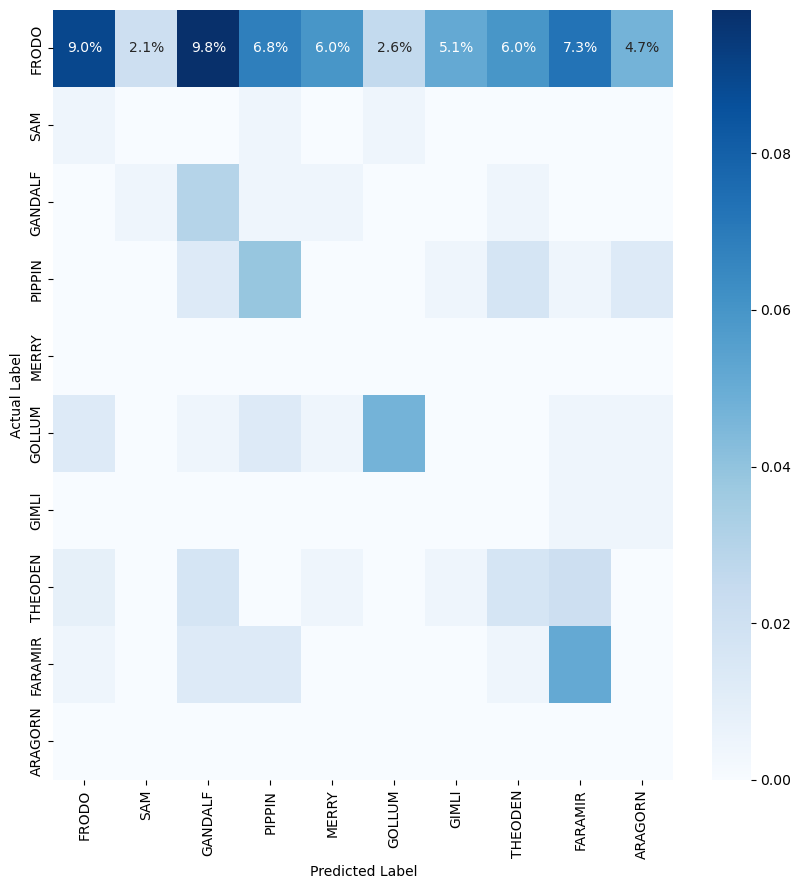

In [201]:
conf_matrix(P1, D_tar_y)

<h3> RNN

In [203]:
evaluate_model(P2, D_tar_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.14      0.25       234
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.14       234
   macro avg       0.10      0.01      0.02       234
weighted avg       1.00      0.14      0.25       234

Accuracy  0.141
f1_score 0.2472
precision_score 1.0
recall_score 0.141


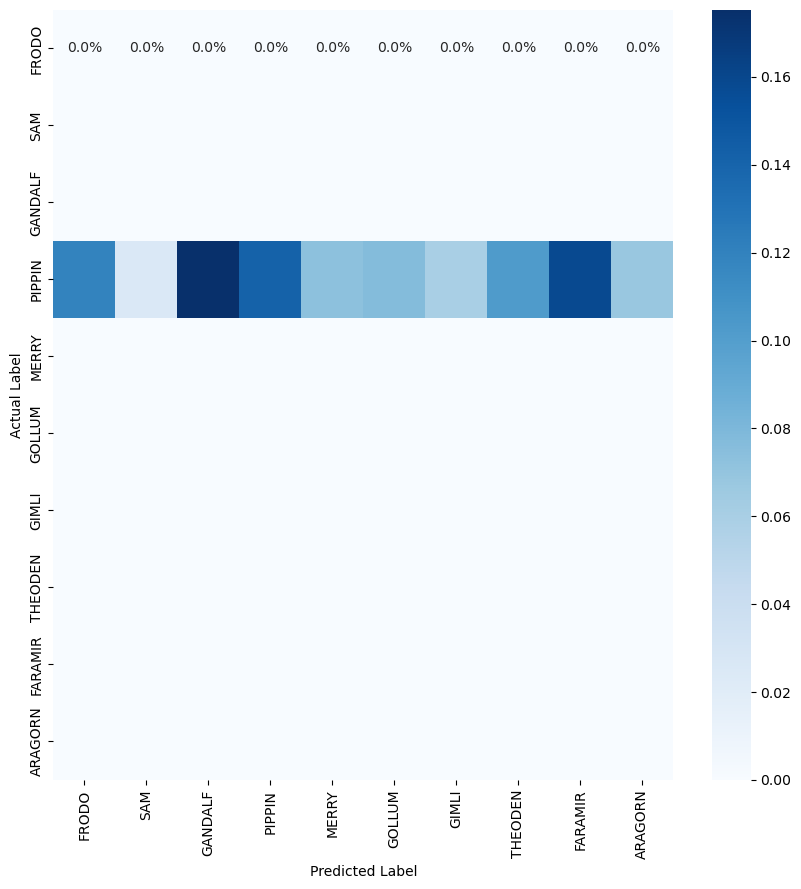

In [204]:
conf_matrix(P2, D_tar_y)

<h3> RFC

In [205]:
evaluate_model(P3, D_tar_y)

              precision    recall  f1-score   support

           0       0.07      0.33      0.12         6
           1       0.00      0.00      0.00         0
           2       0.80      0.22      0.35       150
           3       0.27      0.69      0.39        13
           4       0.00      0.00      0.00         0
           5       0.56      0.45      0.50        22
           6       0.00      0.00      0.00         2
           7       0.17      0.36      0.23        11
           8       0.43      0.57      0.49        28
           9       0.12      1.00      0.22         2

    accuracy                           0.32       234
   macro avg       0.24      0.36      0.23       234
weighted avg       0.65      0.32      0.36       234

Accuracy  0.3248
f1_score 0.3648
precision_score 0.6458
recall_score 0.3248


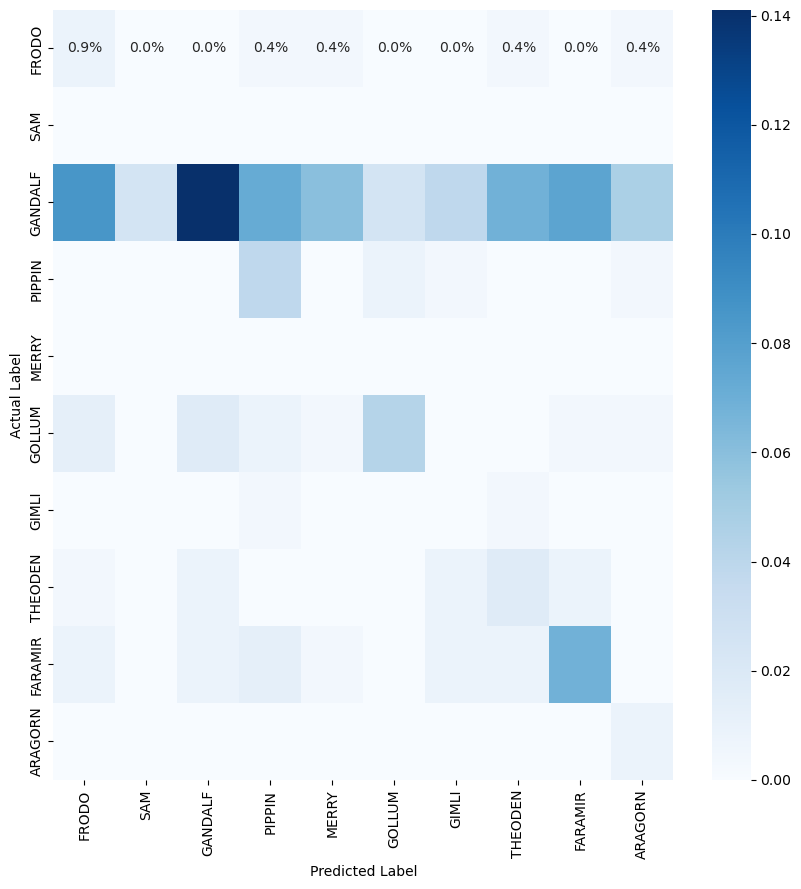

In [206]:
conf_matrix(P3, D_tar_y)

<h3> Ensemble


In [207]:
evaluate_model(final_preds, D_tar_y)

              precision    recall  f1-score   support

           0       0.07      0.50      0.12         4
           1       0.00      0.00      0.00         0
           2       0.76      0.22      0.34       143
           3       0.48      0.52      0.50        31
           4       0.00      0.00      0.00         0
           5       0.56      0.48      0.51        21
           6       0.00      0.00      0.00         1
           7       0.17      0.36      0.23        11
           8       0.41      0.68      0.51        22
           9       0.06      1.00      0.12         1

    accuracy                           0.34       234
   macro avg       0.25      0.38      0.23       234
weighted avg       0.62      0.34      0.38       234

Accuracy  0.3376
f1_score 0.3794
precision_score 0.6236
recall_score 0.3376


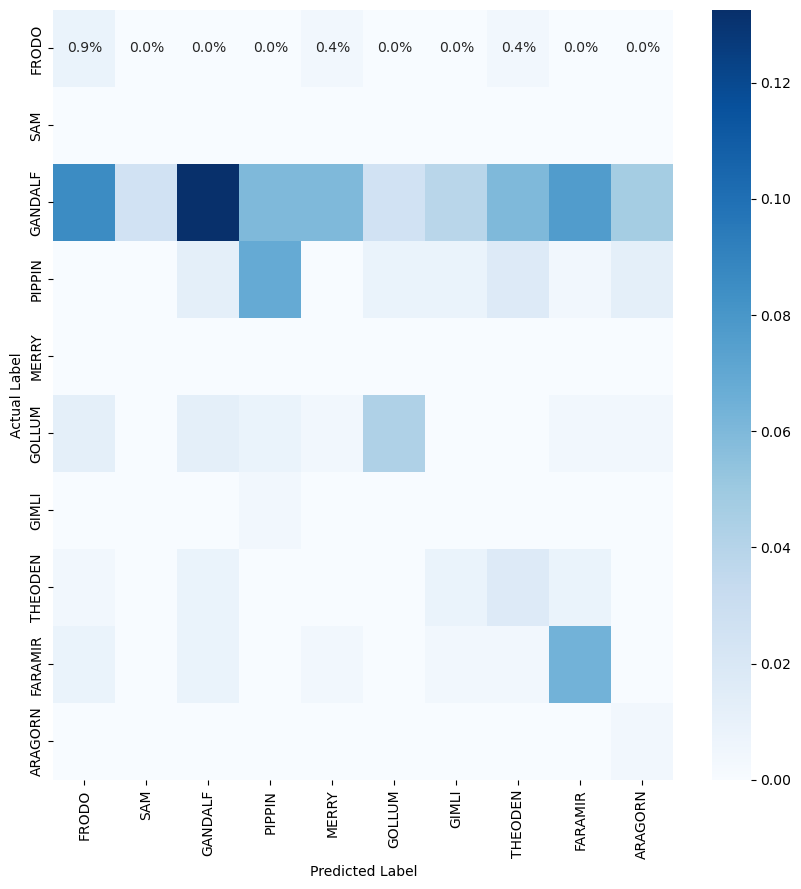

In [208]:
conf_matrix(final_preds, D_tar_y)

<h1> 5. Conclusion: </h1>
<p> We have used three different datasets trained on three different models. The best individual model is the random forest classifier, which is trained on dummy coded BoW. </p>
<br>
<p> Furthermore, all the models have been put together in an ensemble model, where the majority class wins. The accuracy of the ensemble model is equal to the accuracy retrieved from the rfc model. This might indicate that there are no documents where the two other models agrees upon another label than the rfc model. In other words; the other models are do not give any type of additional explanatory power other what than the rfc model gives.</p>
<br>
<p> The upside of the modelling phase is that we have been able to create a model that is better than random guessing by 300% and a model that better than guessing Frodo all the time by approximately 100%. </p>
<br>
<h1> Biological hazard have left the building at 01:55.  </h1>